<a href="https://colab.research.google.com/github/jobende-OSU/CS4783-Assignment2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1

To derive the update rule for a 2-layer neural network using Mean Square Error loss, we must first define a few functions.

First, we will use a sigmoid activation function for our hidden layer, which we define as follows:

$g(z)=\frac{1}{1+\mathrm{e}^{-z}}$

We will also need the derivative of this function, which is seen below:

$g'(z)=g(z) * (1-g(z))$

We also need to define our MSE loss function which we can make easier to work with by expanding it out for only two layers:

$L = \frac{1}{2}(y_1-a_1)+\frac{1}{2}(y_2-a_2)$


Lastly, we must define the outputs for both the first layer and every other layer:

$z_1 = W_1*x + b_1$

$a_1 = g(z_1)$

For all layers past the first:

$z_i = W_i*a_{i-1} + b_i$

$a_i = g(z_i)$

Now we can derive the update rule for our network.


We start with the generic update rule for our weights and bias, using alpha as a learning rate:

$W_i = W_i - \alpha(\frac{\partial L}{\partial W_i})$

$b_i = b_i - \alpha(\frac{\partial L}{\partial b_i})$

To calculate the weight and bias for the second layer, we need to know the partial derivative of the loss function in respect to the weight. 

Because there is no direct relation between them, we must use the chain rule to create one.

$\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial a_2} * \frac{\partial a_2}{\partial z_2} * \frac{\partial z_2}{\partial W_2}$

$\frac{\partial L}{\partial b_2} = \frac{\partial L}{\partial a_2} * \frac{\partial a_2}{\partial z_2} * \frac{\partial z_2}{\partial b_2}$

Using our previous definitions, we can substitute and simplify down to the following:

$\frac{\partial L}{\partial W_2} = (a_2-y)*g'(z_2)*a_1$

$\frac{\partial L}{\partial b_2} = (a_2-y)*g'(z_2)$

We can then continue the chain further to find the first layer.

$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial a_2} * \frac{\partial a_2}{\partial z_2} * \frac{\partial z_2}{\partial a_1} * \frac{\partial a_1}{\partial z_1} * \frac{\partial z_1}{\partial W_1}$

$\frac{\partial L}{\partial b_1} = \frac{\partial L}{\partial a_2} * \frac{\partial a_2}{\partial z_2} * \frac{\partial z_2}{\partial a_1} * \frac{\partial a_1}{\partial z_1} * \frac{\partial z_1}{\partial b_1}$

Substituting and simplifying these give the following:

$\frac{\partial L}{\partial W_1} = (a_2-y)*g'(z_2)*W_2*g'(z_1)*x$

$\frac{\partial L}{\partial b_1} = (a_2-y)*g'(z_2)*W_2*g'(z_1)$

Substituting these partial derivatives gives us the complete update rule for each layer.

$W_1 = W_1 - \alpha((a_2-y)*g'(z_2)*W_2*g'(z_1)*x)$

$b_1 = b_1 - \alpha((a_2-y)*g'(z_2)*W_2*g'(z_1))$

$W_2 = W_2 - \alpha((a_2-y)*g'(z_2)*a_1)$

$b_2 = b_2 - \alpha((a_2-y)*g'(z_2))$

The only difference between these and the update rule when using log loss as the error function is the inclusion of an additional term, $g'(z_2)$, in the final partial derivatives for $\frac{\partial L}{\partial W_i}$. This results from the difference in error functions affecting the first term, $\frac{\partial L}{\partial a_2}$, which generates a value unable which cannot be used to cancel out the output layer's $g'(z_i)$ term.

Derive the update rule and show how to train a 2-layer (1 hidden layer and 1 output layer) neural 
network with backpropagation for regression using the Mean Square Error loss. Assume that you 
are using the Sigmoid activation function for the hidden layer. Explain briefly how this is different 
from the update rule for the network trained for binary classification using log loss. 

# Question 2

First, gain access to the data from Canvas and import NumPy.

In [465]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# Load all the data
x_train = np.loadtxt("/content/drive/MyDrive/X_train.csv")
y_train = np.loadtxt("/content/drive/MyDrive/Y_train.csv")
x_test = np.loadtxt("/content/drive/MyDrive/X_test.csv")
y_test = np.loadtxt("/content/drive/MyDrive/Y_test.csv")

# Reshape the Y data into 2D arrays
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then, define our sigmoid activation function and its derivative.


In [466]:
# Sigmoid Function
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# Derivative Sigmoid Function
def sigmoid_derivative(z):
  g = sigmoid(z)
  return np.multiply(g, (1 - g))

Now, we will initialize our node counts, learning rate, and maximum iterations.

In [467]:
# Initialize Rate, Max Iterations, and Example Count
learning_rate = 0.1
epochs = 5000
count = y_train.size

# Number of Neurons
input_nodes = 2
hidden_nodes = 9
output_nodes = 1

Define a function for forward passes and predictions

In [472]:
def forward_pass(X, W1, W2):
  z1 = np.dot(X, W1)
  a1 = sigmoid(z1)
  z2 = np.dot(a1, W2)
  a2 = z2
  return a2

Definte functions for the error and accuracy

In [469]:
def ms_error(predictions, true):
    return np.sum(pow(predictions - true, 2)) / (2 * predictions.size)
    
def accuracy(predictions, true):
    correct = []
    for i in range(true.shape[0]):
      correct = np.append(correct, predictions[i][0] == true[i][0]) 
    return np.sum(correct) / true.size

Next, define our backwards propogation function to use for training.

In [473]:
def backprop(input_nodes, hidden_nodes, output_nodes, learning_rate, epochs):
  # Initialize Weights
  W1 = np.random.rand(input_nodes, hidden_nodes)   
  W2 = np.random.rand(hidden_nodes, output_nodes) 

  # Initialize Trackers for Error and Accuracy
  err = []
  acc = []

  # Loop until we surpass the maximum allowed iterations
  for iter in range(epochs):
    # Current Prediction
    z1 = np.dot(x_train, W1)
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2)
    a2 = z2
    
    # Calculate and Track Error / Accuracy
    err = np.append(err, ms_error(a2, y_train))
    acc = np.append(acc, accuracy(a2, y_train))
    
    # Compute Gradients
    da1 = (a2 - y_train) * sigmoid_derivative(z2)
    da2 = np.dot(da1, W2.T) * sigmoid_derivative(z1)
    dW1 = np.dot(x_train.T, da2) / count
    dW2 = np.dot(a1.T, da1) / count

    # Update the Weights
    W2 = W2 - learning_rate * dW2
    W1 = W1 - learning_rate * dW1

  return (W1, W2, err, acc)


Finally, train on the data and test predictions on the test set.

Accuracy (Test):  0.0
W1:  [[ 0.14066706  0.23529849  0.04062294  0.28609802 -0.03908999  0.04089983
  -0.02266428  0.02781167  0.03498923]
 [ 2.75848368  1.15350182  4.35378607  1.63091035 -5.40409829  4.04656446
  -3.21040689 -2.42345449  4.84036842]]
W2:  [[ 2.09116459]
 [ 0.38714647]
 [ 4.02865395]
 [ 0.85333792]
 [-7.1158551 ]
 [ 3.64862897]
 [-4.18301769]
 [-3.26039921]
 [ 4.67779182]]


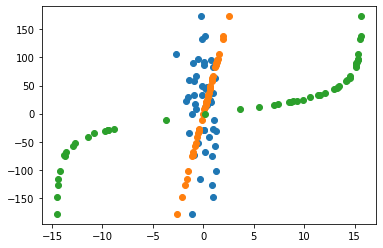

In [474]:
# Train on the training data.
W1, W2, err, acc = backprop(input_nodes, hidden_nodes, output_nodes, learning_rate, epochs)

# Final Prediction
guess = forward_pass(x_test, W1, W2)

# Check the accuracy of the predictions and print it and other results to the console.
acc2 = accuracy(guess, y_test)
print("Accuracy (Test): ", acc2)
print("W1: ", W1)
print("W2: ", W2)

plt.scatter(x_test.T[0], y_test)
plt.scatter(x_test.T[1], y_test)
plt.scatter(guess, y_test)

#print("Expected: ", guess)
#print("Actual: ", y_test)

### Written Questions

1. I will choose to also use the linear function for the output layer because I ran out of time and couldn't figure out which one was correct.
2. There should be 1 neuron since is only one feature in the y data. This would means that each output is a probability of it belonging to our linear classifier.

In [476]:
print("Error: ", err[-1])
print("Accuracy: ", acc[-1])

Error:  2051.1267989044227
Accuracy:  0.0


3. The average MSE loss was ~2100 and the final accuracy is 0% on both data sets. I unfortunately did not have enough time to fix this algorithm before it was due.
4. 


Text(0.5, 0, 'Iterations')

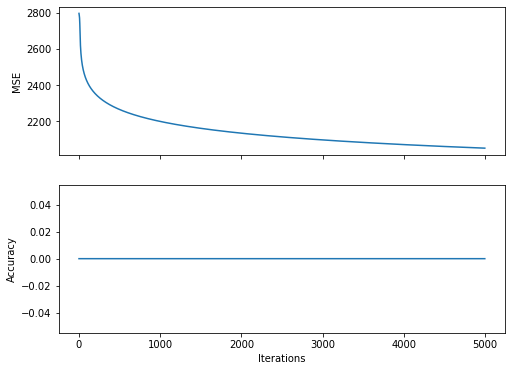

In [477]:
# Import Libraries
import matplotlib.pyplot as plt

# Plot the loss and accuracy
_, ax = plt.subplots(2, figsize = (8, 6), sharex=True)
ax[0].plot(range(epochs), err)
ax[1].plot(range(epochs), acc)
ax[0].set_ylabel("MSE")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Iterations")

5. 


In [478]:
# Initial parameters
rate = 0.001
max_rate = 1.0
acc = []

# Train on the training data.
W1, W2, _, _ = backprop(input_nodes, hidden_nodes, output_nodes, learning_rate, epochs)

# Final Prediction.
guess = forward_pass(x_test, W1, W2)

# Check the accuracy of the predictions and append it to the stored list.
acc = np.append(acc, accuracy(guess, y_test))

# Increase the learning rate.
rate = 0.1

while rate <= max_rate:
  # Train on the training data.
  W1, W2, _, _ = backprop(input_nodes, hidden_nodes, output_nodes, rate, epochs)

  # Final Prediction.
  guess = forward_pass(x_test, W1, W2)

  # Check the accuracy of the predictions and append it to the stored list.
  acc = np.append(acc, accuracy(guess, y_test))
  
  # Increase the learning rate.
  rate = round(rate + 0.1, 1)

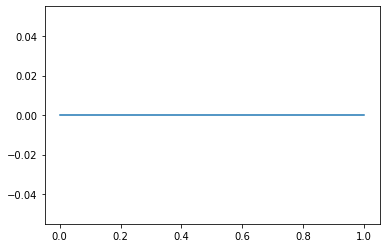

In [479]:
xRange = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.plot(xRange, acc)

6. Increasing the number of neurons in the hidden layer helped to decrease the error substantially, converging best with nine neurons. The update rule does not need to be derived again since the number of neurons in the layer does not affect partial derivatives, only the weights do.


In [484]:
errs = []

for nodes in range(1, 11):
  # Train on the training data.
  W1, W2, error, _ = backprop(input_nodes, nodes, output_nodes, learning_rate, epochs)

  # Final Prediction.
  guess = forward_pass(x_test, W1, W2)

  # Append the final error to the stored list.
  errs = np.append(errs, error[-1])

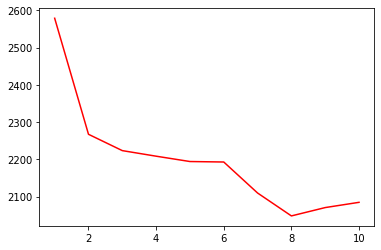

In [486]:
plt.plot(range(1, 11), errs, 'r')

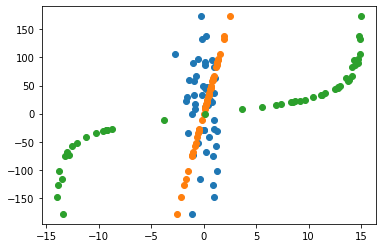

In [487]:
plt.scatter(x_test.T[0], y_test)
plt.scatter(x_test.T[1], y_test)
plt.scatter(guess, y_test)


7. Generally, they offset the predictions on the x-axis. 

   a. Yes, because it involves the derivative of activation functions, it will need to be updated.
  
   b. The derivative activation function used in $\frac{\partial L}{\partial W_i}$ needs to be replaced with the one derived from the new activation function.
  
   c. Using tanh instead of sigmoid for the hidden layer shifts the guesses to the right, and a linear activation function results in no transformations at all.

In [488]:
# TanH function
def tanh(z):
  return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

# TanH derivative function
def tanh_derivative(z):
  return 1 - pow(tanh(z), 2)

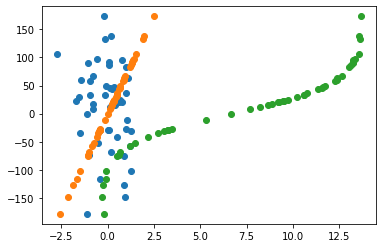

In [489]:
def backprop_tanh(input_nodes, hidden_nodes, output_nodes, learning_rate, epochs):
  # Initialize Weights
  W1 = np.random.rand(input_nodes, hidden_nodes)   
  W2 = np.random.rand(hidden_nodes, output_nodes) 

  # Initialize Trackers for Error and Accuracy
  err = []
  acc = []

  # Loop until we surpass the maximum allowed iterations
  for iter in range(epochs):
    # Current Prediction
    z1 = np.dot(x_train, W1)
    a1 = tanh(z1)
    z2 = np.dot(a1, W2)
    a2 = z2
    
    # Calculate and Track Error / Accuracy
    err = np.append(err, ms_error(a2, y_train))
    acc = np.append(acc, accuracy(a2, y_train))
    
    # Compute Gradients
    da1 = (a2 - y_train) * tanh_derivative(z2)
    da2 = np.dot(da1, W2.T) * tanh_derivative(z1)
    dW1 = np.dot(x_train.T, da2) / count
    dW2 = np.dot(a1.T, da1) / count

    # Update the Weights
    W2 = W2 - learning_rate * dW2
    W1 = W1 - learning_rate * dW1

  return (W1, W2, err, acc)

# Train on the training data.
W1, W2, err, acc = backprop_tanh(input_nodes, hidden_nodes, output_nodes, learning_rate, epochs)
# Final Prediction.
guess = forward_pass(x_test, W1, W2)
# Check the accuracy of the predictions and print it and other results to the console.
err = np.append(err, error[-1])

plt.scatter(x_test.T[0], y_test)
plt.scatter(x_test.T[1], y_test)
plt.scatter(guess, y_test)